# In Lab Exercise 2 st121411

1. See if normalizing X improves the numerical stability for large d.
2. Add the year variable from the monthly sales dataset to your simple linear regression model and quantify whether including it improves test set performance. Show the observations and predictions in a 3D surface plot.
3. Develop polynomial regression models of degree 2 and 3 based on the two input variables. Show results as 3D surface plots and discuss whether you observe overfitting or not.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

In [2]:
#import data

raw_data = np.genfromtxt("../resources/MonthlySales_data.csv",delimiter = ',', dtype=str)
print("raw_data shape:", raw_data.shape)
print("headers:", raw_data[0,:])

raw_data shape: (241, 3)
headers: ['year' 'month' 'sale amount']


In [3]:
#create a normalized version of the data
data_unnormalized = raw_data[1:,:].astype(float)
mean = np.mean(data_unnormalized,axis=0)
std = np.std(data_unnormalized,axis=0)

data_normalized = (data_unnormalized-mean)/std

In [4]:
#create X_unnorm, y_unnorm, X_norm, y_norm
X_unnorm = data_unnormalized[:,[0,1]]
y_unnorm = data_unnormalized[:,2]
print("X_unnorm shape:", X_unnorm.shape)
print("y_unnorm shape:", y_unnorm.shape)

X_norm = data_normalized[:,[0,1]]
y_norm = data_normalized[:,2]
print("X_norm shape:", X_norm.shape)
print("y_norm shape:", y_norm.shape)

m = X_unnorm.shape[0]
n = X_unnorm.shape[1]
print("m:",m)
print("n:",n)

X_unnorm shape: (240, 2)
y_unnorm shape: (240,)
X_norm shape: (240, 2)
y_norm shape: (240,)
m: 240
n: 2


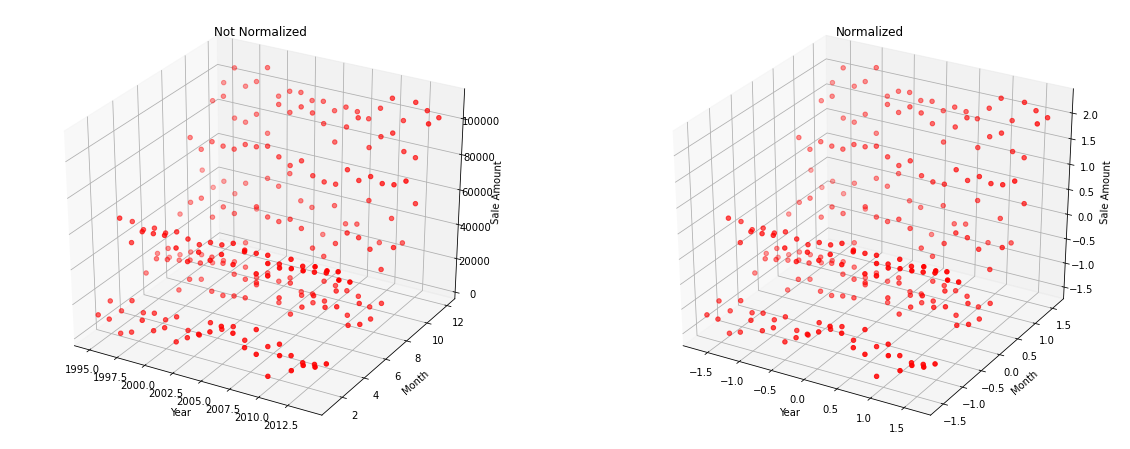

In [5]:
#plot out both the normalized and the normal one

fig = plt.figure(figsize=(20,8))
gs = fig.add_gridspec(1, 2)

fig_unnorm = fig.add_subplot(gs[0,0], projection='3d')
fig_unnorm.set_title("Not Normalized")
fig_norm = fig.add_subplot(gs[0,1], projection='3d')
fig_norm.set_title("Normalized")

fig_unnorm.scatter(X_unnorm[:,0], X_unnorm[:,1], y_unnorm, c='r', marker='o')
fig_norm.scatter(X_norm[:,0], X_norm[:,1], y_norm, c='r', marker='o')

fig_unnorm.set_xlabel('Year')
fig_unnorm.set_ylabel('Month')
fig_unnorm.set_zlabel('Sale Amount')
fig_norm.set_xlabel('Year')
fig_norm.set_ylabel('Month')
fig_norm.set_zlabel('Sale Amount')

plt.show()

By normalizing the data, the x, y, and z axes have relatively similar range.

In [6]:
#partition the data into training and test data

idx = np.arange(0,m)
random.shuffle(idx)

percent_train = .6
m_train = int(m * percent_train)
train_idx = idx[0:m_train]
test_idx = idx[m_train:m+1]

X_unnorm_train = X_unnorm[train_idx]
X_unnorm_test = X_unnorm[test_idx]
y_unnorm_train = y_unnorm[train_idx]
y_unnorm_test = y_unnorm[test_idx]

X_norm_train = X_norm[train_idx]
X_norm_test = X_norm[test_idx]
y_norm_train = y_norm[train_idx]
y_norm_test = y_norm[test_idx]

In [7]:
#Functions for regression
from itertools import combinations_with_replacement

# Cost function normalized by number of examples
def J(theta,X,y):
    return 1 /(2*X.shape[0]) * (h(X,theta)-y).T.dot(h(X,theta)-y)

# Get design matrix for polynomial model of degree d
def x_polynomial(x, d):
    x_new = x
    for n in np.arange(2,d+1):
        comb = combinations_with_replacement(np.arange(x.shape[1]),n)
        for pair in comb:
            x_new_column = np.ones((x.shape[0],1))
            for i in pair:
                vector = x[:,i].reshape(-1,1)
                x_new_column = x_new_column*vector
            x_new = np.concatenate((x_new,x_new_column),axis=1)
    
    x_new = np.concatenate((np.ones(x.shape[0]).reshape(-1,1),x_new),axis=1)
    return x_new

# Expects an mxn matrix, returns mx(n+degree) matrix for polynomial regression
def get_predictions(x, theta):
    x = np.insert(x, 0, 1, axis=1)
    while(x.shape[1] < theta.shape[0]):
        x = np.insert(x, x.shape[1], x[:,1] * x[:,-1], axis=1)
    y = h(x, theta)
    return y

def get_predictions2(x, theta):
    theta = theta.reshape(-1,1)
    y = x@theta
    return y

def h(X, theta):
    return X.dot(theta)

# Solve the normal equations
def regress(X, y):
    cov = np.dot(X.T, X)
    cov_inv = np.linalg.inv(cov)
    theta = np.dot(cov_inv, np.dot(X.T, y))
    return theta

# RMSE (root mean squared error) metric for prediction accuracy
def rmse(y, y_pred):
    return np.sqrt(np.dot((y - y_pred).T, y - y_pred) / m)

def r_squared(y, y_pred):
    return 1 - np.square(y - y_pred).sum() / np.square(y - y.mean()).sum()

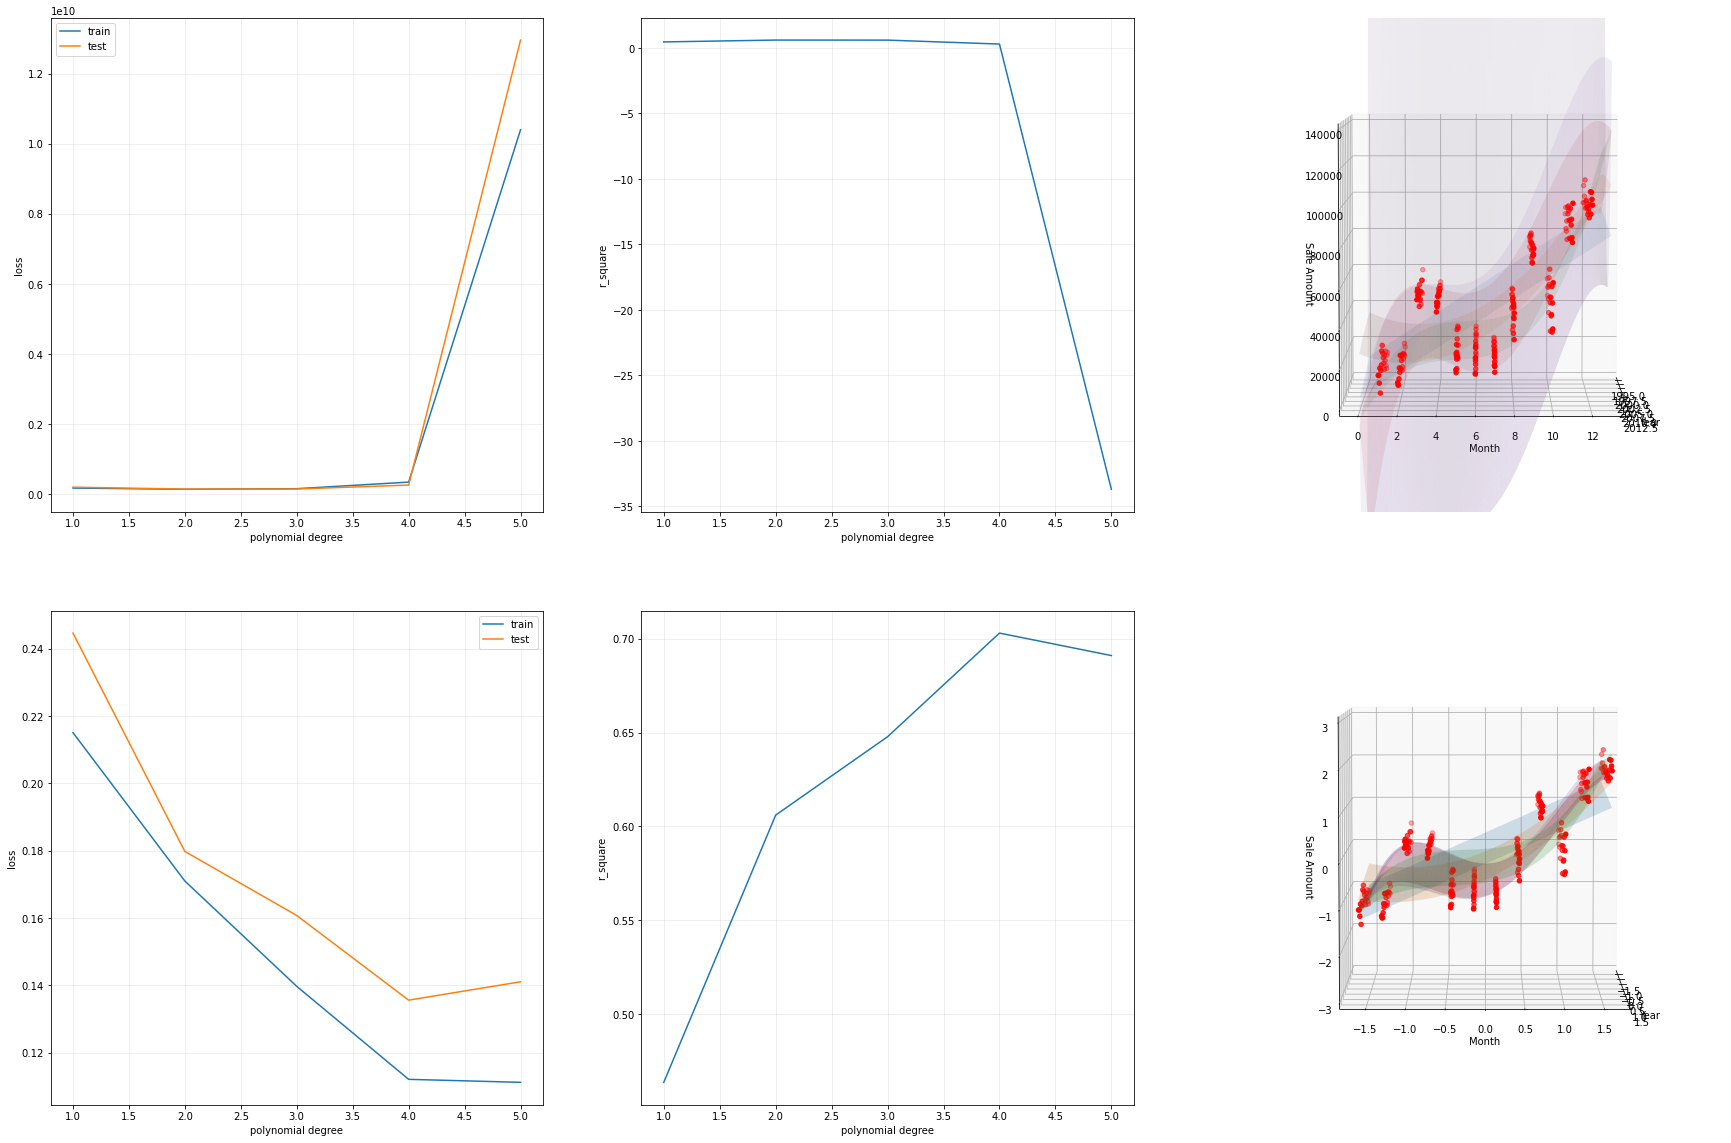

In [10]:
#find prediction for normalized and non-normalized versions

min_degree = 1
max_degree = 5

J_unnorm_train = np.zeros(max_degree-min_degree+1)
J_unnorm_test = np.zeros(max_degree-min_degree+1)

J_norm_train = np.zeros(max_degree-min_degree+1)
J_norm_test = np.zeros(max_degree-min_degree+1)

r_unnorm = np.zeros(max_degree-min_degree+1)
r_norm = np.zeros(max_degree-min_degree+1)

# Initalize plots for predictions and loss
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2, 3)
fig_unnorm_cost = fig.add_subplot(gs[0,0])
fig_unnorm_plot = fig.add_subplot(gs[0,2], projection='3d')
fig_norm_cost = fig.add_subplot(gs[1,0])
fig_norm_plot = fig.add_subplot(gs[1,2], projection='3d')
fig_unnorm_r = fig.add_subplot(gs[0,1])
fig_norm_r = fig.add_subplot(gs[1,1])

fig_norm_plot.set_zlim([-3,3])
fig_unnorm_plot.set_zlim([0,140000])

fig_unnorm_plot.scatter(X_unnorm[:,0], X_unnorm[:,1], y_unnorm, c='r', marker='o')
fig_unnorm_plot.set_xlabel('Year')
fig_unnorm_plot.set_ylabel('Month')
fig_unnorm_plot.set_zlabel('Sale Amount')

fig_norm_plot.scatter(X_norm[:,0], X_norm[:,1], y_norm, c='r', marker='o')
fig_norm_plot.set_xlabel('Year')
fig_norm_plot.set_ylabel('Month')
fig_norm_plot.set_zlabel('Sale Amount')

fig_norm_plot.view_init(5, 0)
fig_unnorm_plot.view_init(5, 0)

for i in range(min_degree, max_degree+1):
    # Fit model on training data and get cost for training and test data
    Xi_unnorm_train = x_polynomial(X_unnorm_train, i)    
    Xi_unnorm_test = x_polynomial(X_unnorm_test, i)
    
    Xi_norm_train = x_polynomial(X_norm_train, i)    
    Xi_norm_test = x_polynomial(X_norm_test, i);

    theta_unnorm = regress(Xi_unnorm_train, y_unnorm_train)  
    J_unnorm_train[i-min_degree] = J(theta_unnorm, Xi_unnorm_train, y_unnorm_train)
    y_unnorm_pred_test = h(Xi_unnorm_test, theta_unnorm)
    J_unnorm_test[i-min_degree] = J(theta_unnorm, Xi_unnorm_test, y_unnorm_test)
    
    theta_norm = regress(Xi_norm_train, y_norm_train)  
    J_norm_train[i-min_degree] = J(theta_norm, Xi_norm_train, y_norm_train)
    y_norm_pred_test = h(Xi_norm_test, theta_norm)
    J_norm_test[i-min_degree] = J(theta_norm, Xi_norm_test, y_norm_test)
    
    r_unnorm[i-min_degree] = r_squared(y_unnorm_test, y_unnorm_pred_test)
    r_norm[i-min_degree] = r_squared(y_norm_test, y_norm_pred_test)
    
    # Plot
    spacing = 100
    x_unnorm_series = np.linspace(1995,2013,spacing)
    y_unnorm_series = np.linspace(0, 13, spacing)
    
    x_norm_series = np.linspace(np.min(X_norm[:,0]),np.max(X_norm[:,0]),spacing)
    y_norm_series = np.linspace(np.min(X_norm[:,1]),np.max(X_norm[:,1]), spacing)
    
    x_unnorm_series, y_unnorm_series = np.meshgrid(x_unnorm_series, y_unnorm_series)
    X_Y = np.concatenate((x_unnorm_series.reshape(-1,1), y_unnorm_series.reshape(-1,1)), axis=1) 
    X_Y = x_polynomial(X_Y, i)
    z_unnorm = get_predictions2(X_Y, theta_unnorm).reshape(spacing,spacing)

    x_norm_series, y_norm_series = np.meshgrid(x_norm_series, y_norm_series)
    X_Y = np.concatenate((x_norm_series.reshape(-1,1), y_norm_series.reshape(-1,1)), axis=1) 
    X_Y = x_polynomial(X_Y, i)
    z_norm = get_predictions2(X_Y, theta_norm).reshape(spacing,spacing)

    
    fig_unnorm_plot.plot_surface(x_unnorm_series,y_unnorm_series,z_unnorm,alpha=0.1,label='degree ' + str(i) + ' (test accuracy ' + str(r_squared(y_unnorm_test, y_unnorm_pred_test)) + ')')
    fig_norm_plot.plot_surface(x_norm_series,y_norm_series,z_norm,alpha=0.2,label='degree ' + str(i) + ' (test accuracy ' + str(r_squared(y_norm_test, y_norm_pred_test)) + ')')
    
fig_unnorm_cost.plot(np.arange(min_degree, max_degree + 1, 1), J_unnorm_train, '-', label='train')
fig_unnorm_cost.plot(np.arange(min_degree, max_degree + 1, 1), J_unnorm_test, '-', label='test')
fig_unnorm_cost.set_xlabel('polynomial degree')
fig_unnorm_cost.set_ylabel('loss')
fig_unnorm_cost.grid(axis='both', alpha=.25)
fig_unnorm_cost.legend()

fig_norm_cost.plot(np.arange(min_degree, max_degree + 1, 1), J_norm_train, '-', label='train')
fig_norm_cost.plot(np.arange(min_degree, max_degree + 1, 1), J_norm_test, '-', label='test')
fig_norm_cost.set_xlabel('polynomial degree')
fig_norm_cost.set_ylabel('loss')
fig_norm_cost.grid(axis='both', alpha=.25)
fig_norm_cost.legend()

fig_unnorm_r.plot(np.arange(min_degree, max_degree + 1, 1), r_unnorm, '-')
fig_unnorm_r.set_xlabel('polynomial degree')
fig_unnorm_r.set_ylabel('r_square')
fig_unnorm_r.grid(axis='both', alpha=.25)

fig_norm_r.plot(np.arange(min_degree, max_degree + 1, 1), r_norm, '-')
fig_norm_r.set_xlabel('polynomial degree')
fig_norm_r.set_ylabel('r_square')
fig_norm_r.grid(axis='both', alpha=.25)

plt.show()

The graph above shows the loss function, r_square, and the surface plot of the predictions. The maximum order is set to 5 and we can draw several conclusions from these graphs.

Firstly, it could be clearly seen that normalizing the data helps with finding the inverse of higher order polynomials' matrices. 

Furthermore the loss function graph of the normalized data shows that increasing the order continues to decrease the training set error but due to overfitting, the test set error doesn't decrease with the training set after the 4th order. The maximum r_square is achieved at the 4th order and with an r_square of >0.7. 